**Step # 1: Installing Required Libraries**

---



In [5]:
# Installing the Required Libraries
%%capture --no-stderr
pip install langgraph langchain_core langchain_google_genai python-dotenv tavily-python langchain_community

**Step # 2: Importing Packages**

---

In [11]:
# Importing Packages
from typing import Dict, TypedDict
from langgraph.graph import StateGraph, END, START
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai import ChatGoogleGenerativeAI

from IPython.display import display, Image
from langchain_core.runnables.graph import MermaidDrawMethod
from dotenv import load_dotenv
import os


**Step # 3: Load Environment Variables and Set API Keys**

---

In [7]:
# Load environment variables and set API key
load_dotenv()

from google.colab import userdata
os.environ["GEMINI_API_KEY"]=userdata.get('GEMINI_API_KEY')
os.environ["TAVILY_API_KEY"]=userdata.get("TAVILY_API_KEY")
os.environ["GOOGLE_API_KEY"]=userdata.get("GOOGLE_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=userdata.get("LANGCHAIN_API_KEY")

**Step # 4 : Define State Structure**

---

In [8]:
# Define State Structure
from typing_extensions import Annotated
from langgraph.graph import add_messages

class State(TypedDict):
    query: str
    category: str
    sentiment: str
    response: str
    messages: Annotated[list, add_messages]



**Step # 5 : Define Function Nodes**

---

In [9]:
#  Define the functions/nodes
def categorize(state: State) -> State:
    """Categorize the user query into English, Math or Science."""
    prompt = ChatPromptTemplate.from_template(
        "Categorize the following user query into one of these categories: "
        "English, Math or Science. Query: {query}"
    )
    chain = prompt | ChatGoogleGenerativeAI(temperature=0,model="gemini-2.0-flash-exp",api_key=userdata.get('GEMINI_API_KEY'))
    category = chain.invoke({"query": state["query"]}).content
    return {"category": category}


def handle_english(state: State) -> State:
    """Provide a English Language related response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a english language related response to the following user query: {query}"
    )
    chain = prompt | ChatGoogleGenerativeAI(temperature=0,model="gemini-2.0-flash-exp",api_key=userdata.get('GEMINI_API_KEY'))
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def handle_math(state: State) -> State:
    """Provide a Math related response to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a Math related response to the following user query: {query}"
    )
    chain = prompt | ChatGoogleGenerativeAI(temperature=0,model="gemini-2.0-flash-exp",api_key=userdata.get('GEMINI_API_KEY'))
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def handle_science(state: State) -> State:
    """Provide a Science related to the query."""
    prompt = ChatPromptTemplate.from_template(
        "Provide a Science related response to the following user query: {query}"
    )
    chain = prompt | ChatGoogleGenerativeAI(temperature=0,model="gemini-2.0-flash-exp",api_key=userdata.get('GEMINI_API_KEY'))
    response = chain.invoke({"query": state["query"]}).content
    return {"response": response}

def route_query(state: State) -> str:
    """Route the query based on its category."""
    if state["category"] == "English":
        return "handle_english"
    elif state["category"] == "Math":
        return "handle_math"
    else:
        return "handle_science"

**Step # 6 : Define Graph , Add Nodes , Specify Route and Compile Graph**

---

In [14]:
# Create the graph
graph = StateGraph(State)

# Add nodes
graph.add_node("categorize", categorize)
graph.add_node("handle_english", handle_english)
graph.add_node("handle_math", handle_math)
graph.add_node("handle_science", handle_science)


# Add edges
graph.add_edge(START, "categorize")
graph.add_conditional_edges(
    "categorize",
    route_query,
    {
        "handle_english": "handle_english",
        "handle_math": "handle_math",
        "handle_science": "handle_science",
    }
)
graph.add_edge("handle_english", END)
graph.add_edge("handle_math", END)
graph.add_edge("handle_science", END)


# Compile the graph
app = graph.compile()



**Step # 7 : Display Graph / Visual Representation**

---

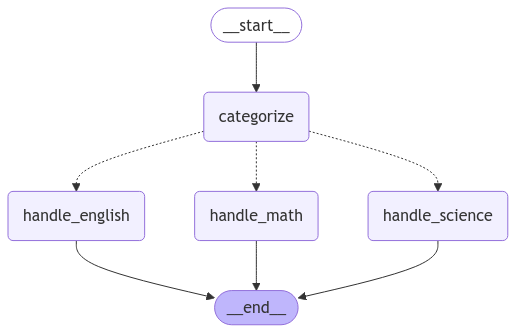

In [15]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

**Step # 8 : Define Function To Test the Graph Working**

---

In [16]:
# Define Function to Test the Working
def run_test_function(query: str) -> Dict[str, str]:
    """Process User query through the LLM and LangGraph .

    Args:
        query (str): The user's query

    Returns:
        Dict[str, str]: A dictionary containing the query's Category and Response
    """
    results = app.invoke({"query": query})
    return {
        "category": results["category"],
        "response": results["response"]
    }


**Step # 9 : Define the Program that takes Continous Inputs and Process User Query**

---

In [17]:
# Define the Program to take user inputs till user types exit
def main():
    while True:
        query = input("Please enter your query (or type 'exit' to quit): ")
        if query.lower() == 'exit':
            print("Goodbye!")
            break

        result = run_test_function(query)
        print(f"Query: {query}")
        print(f"Category: {result['category']}")
        print(f"Response: {result['response']}")
        print("\n")

if __name__ == "__main__":
    main()


Please enter your query (or type 'exit' to quit): What is the difference between Verb and Adverb
Query: What is the difference between Verb and Adverb
Category: **English**
Response: Okay, let's break down the difference between verbs and adverbs from a scientific perspective, focusing on their function within the structure of language as a system:

**Verbs: The Action Core**

* **Function:** Verbs are the fundamental building blocks of a sentence, representing **actions, occurrences, or states of being.** They are the dynamic elements that describe what is happening.
* **Scientific Analogy:** Think of verbs as the **processes** in a system. Just like a chemical reaction (e.g., *reacts*), a physical movement (e.g., *moves*), or a biological function (e.g., *grows*), verbs describe the active changes or conditions within a sentence.
* **Examples:**
    * **Action:** *The bird **flies**.* (The verb "flies" describes the action of the bird.)
    * **Occurrence:** *The rain **fell**.* (The